# Measure sample misalignment uCT

- By: [Alfonso Dario Santamaria](https://github.com/AlphoSM), [Gianluigi Crimi](https://github.com/gcrimi), Martino Pani, [Gianluca Iori](https://github.com/gianthk), Enrico Schileo, Fulvia Taddei, Giulia Fraterrigo, 2025
  
- Code license: MIT
- Narrative license: CC-BY-NC-SA


---
---

# 📌 Aims

The aim of this notebook is to measure the misalignment of a trabecular bone sample acquired by micro-CT (uCT).  
We will process the scanned data, segment the structure, and calculate the best-fit axis to quantify the deviation from perfect alignment.

**How the aims will be developed:**
1. Load and inspect the micro-CT dataset.
2. Pre-process the 3D volume (smoothing, thresholding, cleaning).
3. Extract 2D slices, fit ellipses, and compute centroids along the Z-axis.
4. Calculate the best-fit line through centroids and evaluate misalignment metrics.
5. Visualize results and report key alignment parameters.
6. Mesh generation
    - Generate 3D Unstructured Grid mesh of 4 node-tetrahedra
    - Generate high-resolution mesh of triangles of the model outer shell (optional for visualization)
    - Mesh conversion from tetra4 to tetra10 
7. Generate tetrahedra-FE model for simulation in CalculX or Abaqus from 3D Unstructured Grid mesh 
    - Linear, static analysis definition: uniaxial compression test
8. Launch simulation in Calculix. For info on the solver visit the [Calculix homepage](http://www.calculix.de/)
9. Convert Calculix output to .VTK for visualization in Paraview
10. Calculate apparent elastic modulus from reaction forces

---
## Notes on ciclope
* Tetrahedra meshes are generated with [pygalmesh](https://github.com/nschloe/pygalmesh) (a Python frontend to [CGAL](https://www.cgal.org/))
* High-resolution surface meshes for visualization are generated with the [PyMCubes](https://github.com/pmneila/PyMCubes) module.
* All mesh exports are performed with the [meshio](https://github.com/nschloe/meshio) module.
* **ciclope** handles the definition of material properties and FE analysis parameters (e.g. boundary conditions, simulation steps..) through separate template files. The folders [material_properties](https://github.com/gianthk/ciclope/tree/master/material_properties) and [input_templates](https://github.com/gianthk/ciclope/tree/master/input_templates) contain a library of template files that can be used to generate FE simulations.
  * Additional libraries of [CalculiX](https://github.com/calculix) examples and template files can be found [here](https://github.com/calculix/examples) and [here](https://github.com/calculix/mkraska)
___

---

## 📑 Table of Contents

1. [Configuration and imports](#configuration-and-imports)
2. [Load Input Data](#load-input-data)
3. [Pre-processing](#pre-processing)
4. [Slice Analysis & Ellipse Fitting](#slice-analysis--ellipse-fitting)
5. [Compute Best-Fit Line through Barycenters](#compute-best-fit-line-through-barycenters)
6. [Computational workflow](#computational-workflow)
7. [Write Abaqus input FE files](#write-abaqus-input-fe-files)
8. [Solve FE model in Calculix](#solve-fe-model-in-calculix)
9. [Convert Calculix output to Paraview](#convert-calculix-output-to-paraview)
10. [Post-process FE analysis results](#post-process-fe-analysis-results)
11. [Dependencies](#dependencies)
12. [Acknowledgements](#acknowledgements)
---


## Configuration and imports

In [1]:
import sys
sys.path.append('./../../')

In [2]:
import os
import glob
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import shutil

from scipy import ndimage, misc
from skimage import measure, morphology
from skimage.filters import gaussian, threshold_otsu

import math
import meshio

In [3]:
import ciclope
from ciclope.core import tetraFE

from ciclope.utils.recon_utils import read_tiff_stack, plot_midplanes
from ciclope.utils.preprocess import remove_unconnected, replace_ElType_ref
from ciclope.utils.postprocess import calculate_total_force, sample_height
from ciclope.utils.timer import Timer
from ciclope.utils import misalignment
from ciclope.utils.misalignment import circle_slice_uCT_trab_bone, best_fit_segment_3d

C:\Users\utente\anaconda3\envs\ciclope_env\Lib\site-packages\ciclope\utils\postprocess.py:16: RuntimeWarning: ParaView.simple is required!
  warnings.warn("ParaView.simple is required!", RuntimeWarning)


[ccx2paraview](https://github.com/calculix/ccx2paraview) is needed for the postprocessing of results

In [4]:
from ccx2paraview import Converter

In [5]:
matplotlib.rcParams['figure.dpi'] = 300

font = {'weight' : 'normal',
        'size'   : 6}

plt.rc('font', **font)

## Load input data

In [6]:
input_data = './../../test_data/LHDL/Ti_2923_D_1/resampled/Ti_2923_D_1_0000.tif'

Input data description

|Scan parameters|   |
|:-|:-|
|Lab|LTM@IOR Bologna|
|Sample|Human trabecular bone|
|Voxel size|19.5 micron|
|Preliminary operations|cropped to 257x257x495 (diameter ≈ 5mm)|

Read the input data and define an array of the voxelsize

In [7]:
data_3D = read_tiff_stack(input_data)
vs = np.ones(3)*19.5e-3 # [mm]

Inspect the dataset

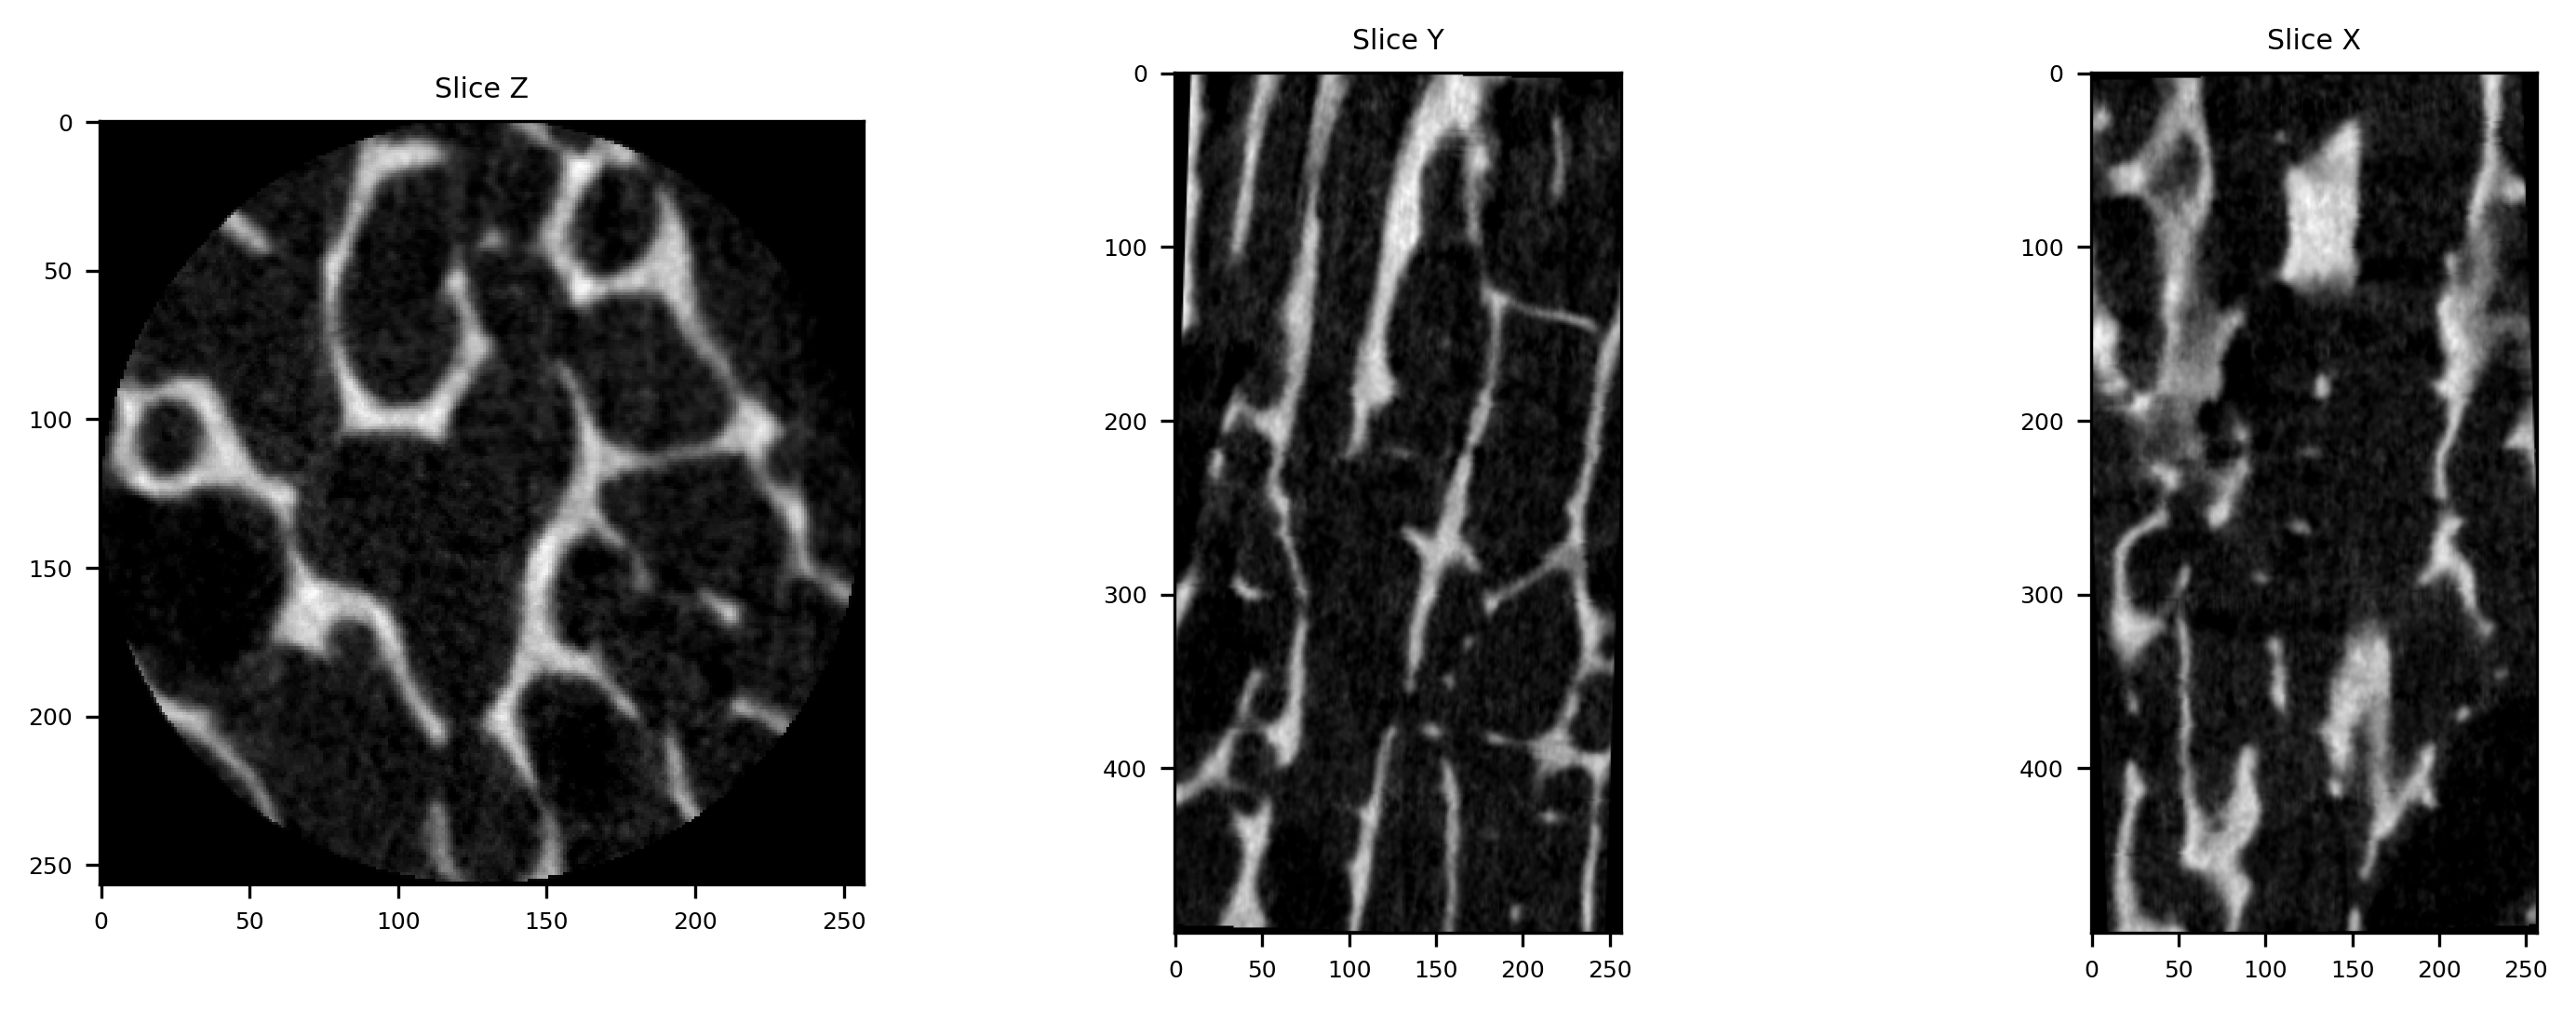

In [8]:
plot_midplanes(data_3D)
plt.show()

## Pre-processing

### Gaussian smooth

In [9]:
data_3D = gaussian(data_3D, sigma=1, preserve_range=True)

### Resize (optional)

If you do not want to resample, set resampling equal to 1, as this variable will be needed in post-processing anyway

In [10]:
resampling = 1

# resize the 3D data using spline interpolation of order 2
data_3D = ndimage.zoom(data_3D, 1/resampling, output=None, order=2)

# correct voxelsize
vs = vs * resampling

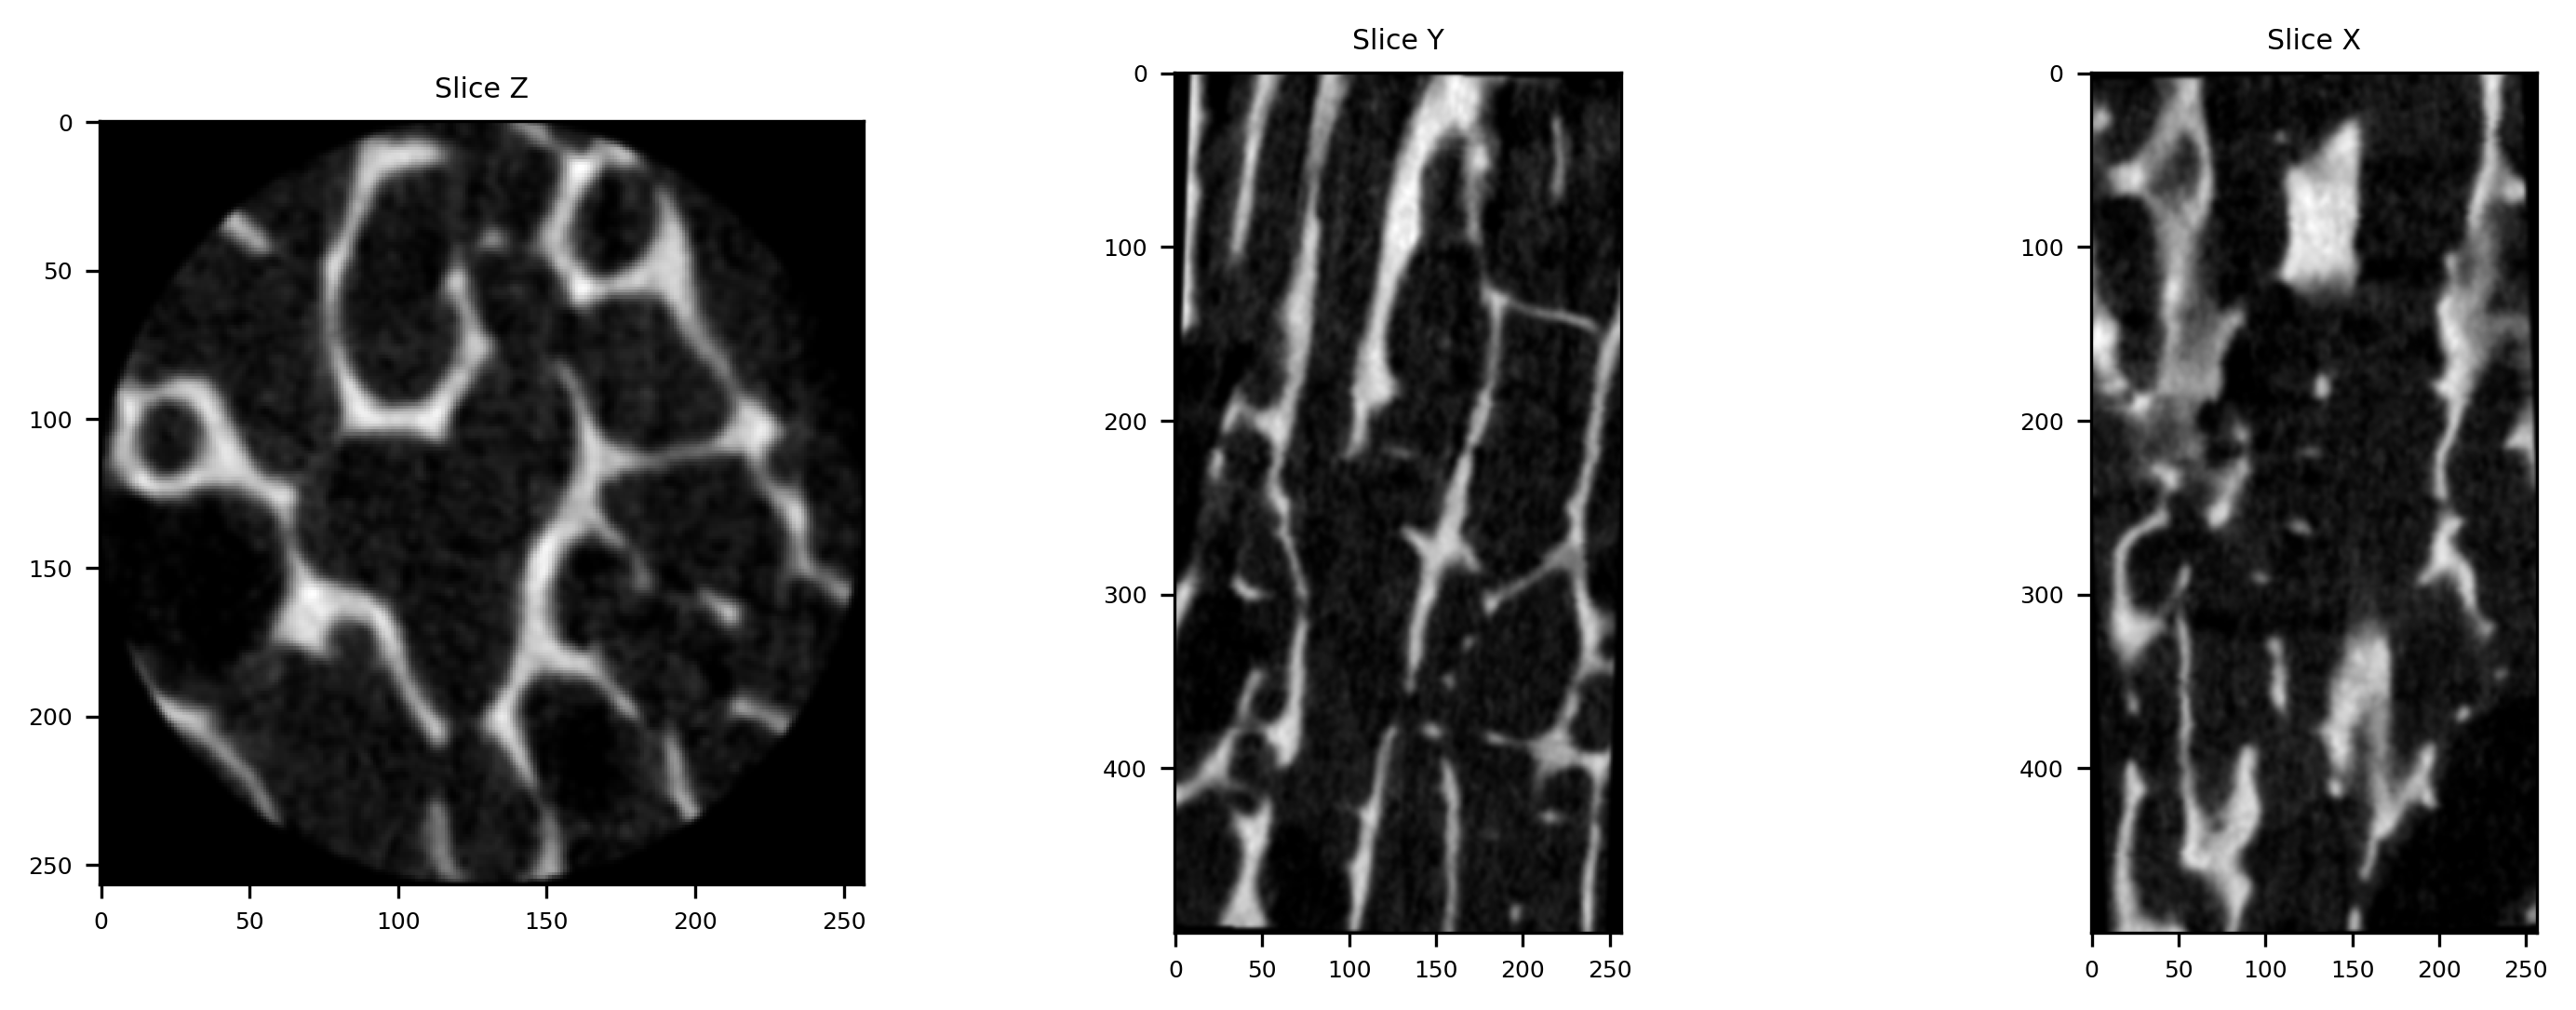

In [11]:
# Inspect again the dataset
plot_midplanes(data_3D)
plt.show()

### Thresholding
Use Otsu's method

In [12]:
T = threshold_otsu(data_3D)
print("Threshold: {}".format(T))

Threshold: 73.892855537282


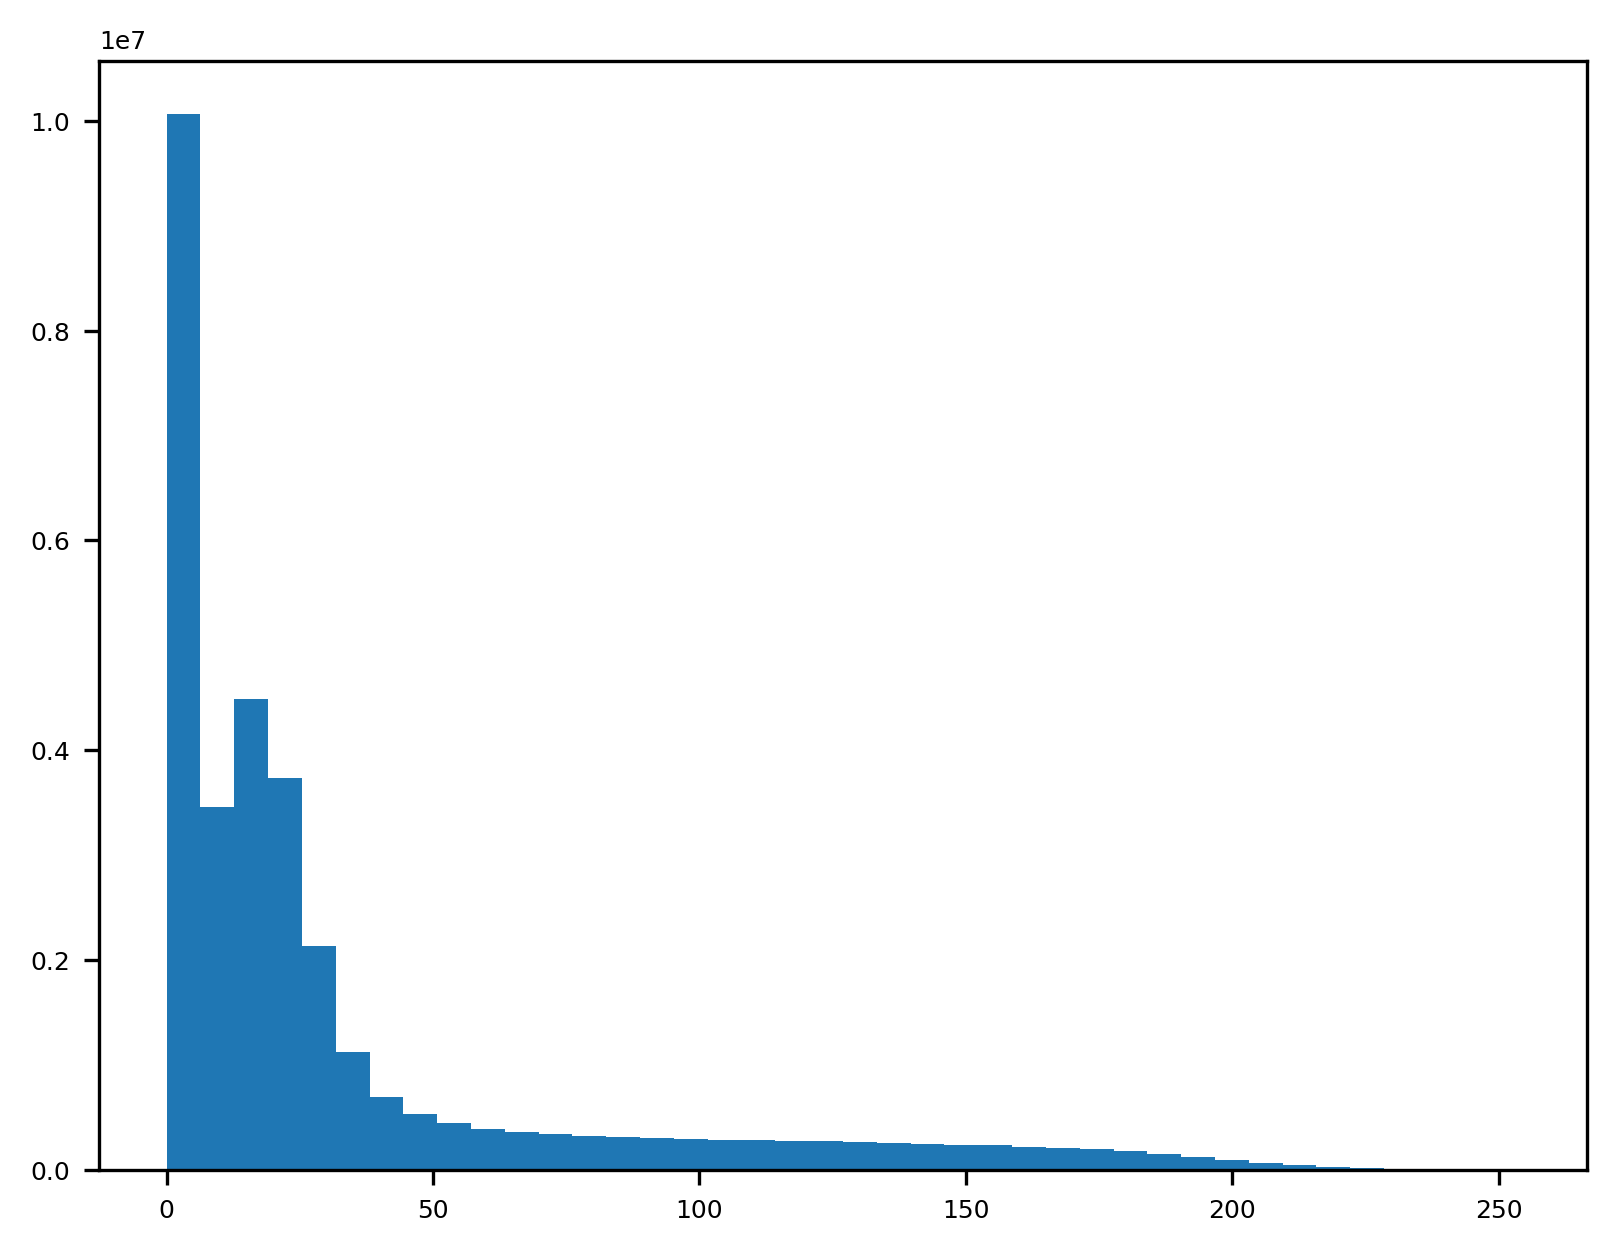

In [13]:
# plot the input image histogram
fig2, ax2 = plt.subplots()
plt.hist(data_3D.ravel(), bins=40)
plt.show()

Apply the threshold manually

In [14]:
BW = data_3D >= 63

### Detect and remove largest isolated cluster of voxels

In [15]:
L = remove_unconnected(BW)

Inspect binary mask

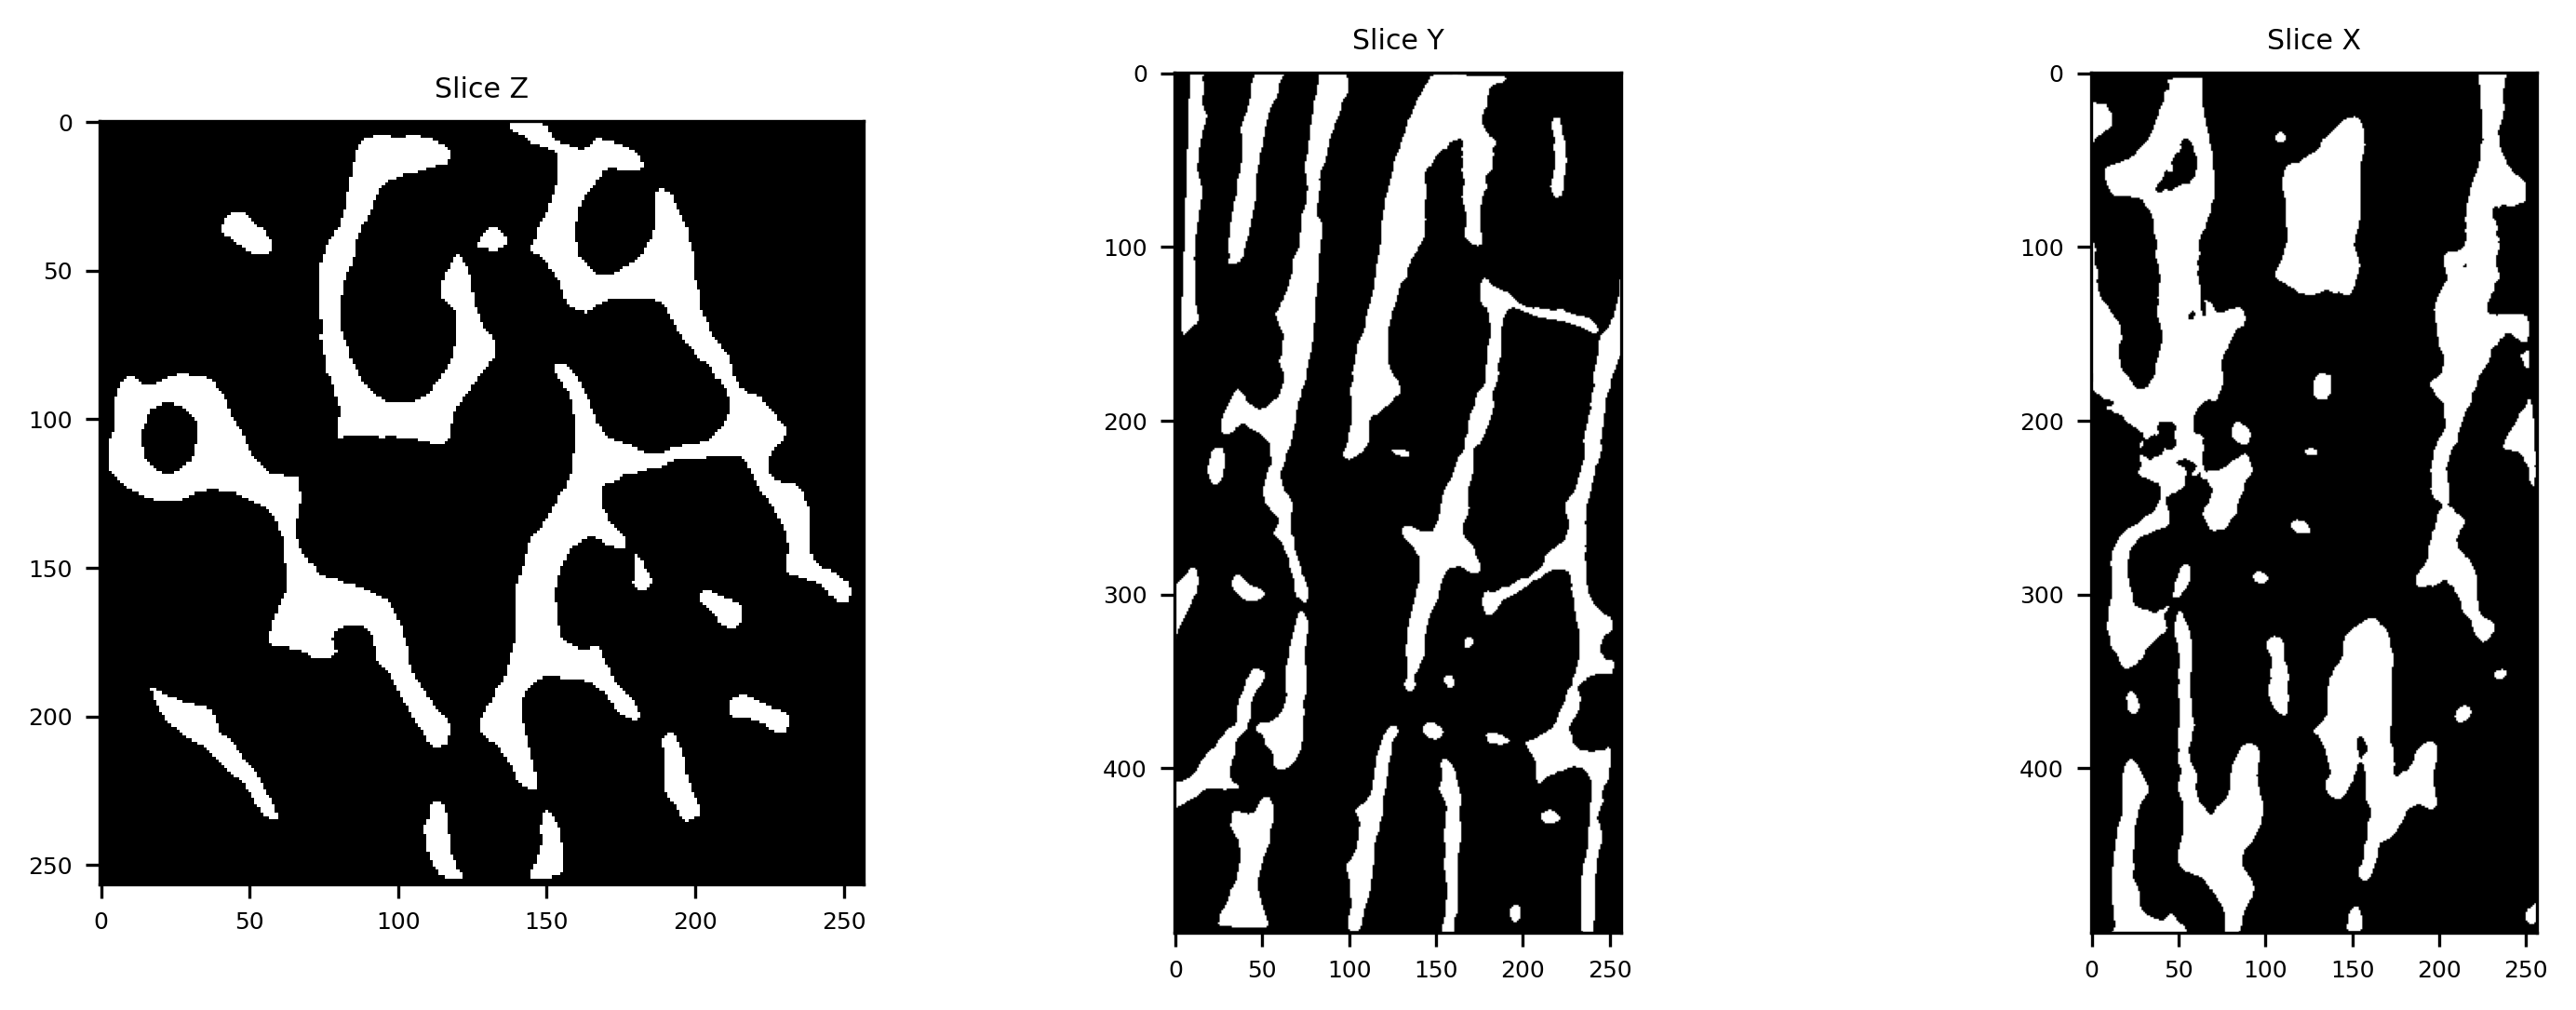

In [16]:
plot_midplanes(L)
plt.show()

z-levels: assume sequential integer indices or actual Z spacing

In [17]:
z_levels = np.arange(0, L.shape[0])

## Slice Analysis & Ellipse Fitting

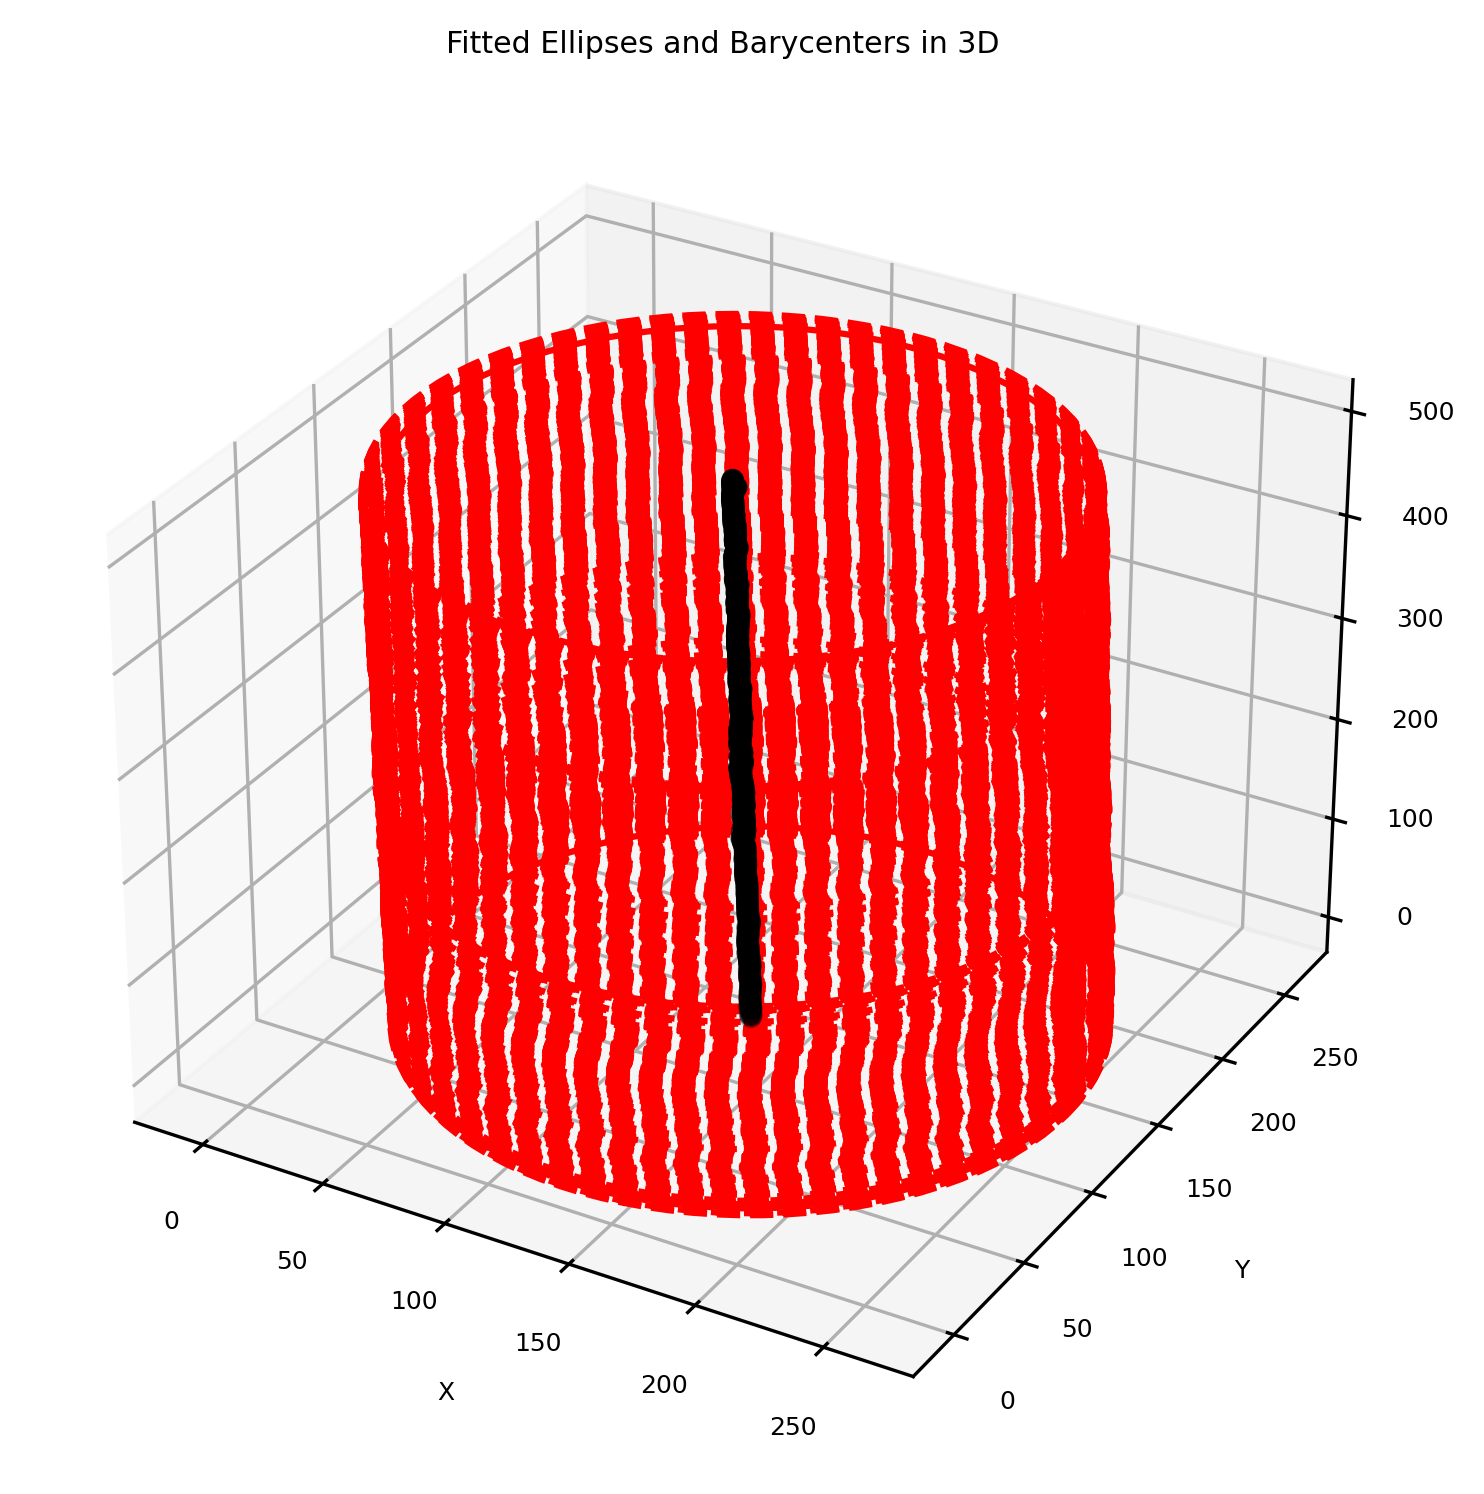

In [18]:
fig = plt.figure(figsize=(6, 6))
ax = fig.add_subplot(111, projection='3d')

# Initialize lists
ecc_list = []   # eccentricities
G_list = []     # [X, Y, Z]

for z in range(L.shape[0]):
    slice_2d = L[z]
    C, a, b, coords, hull_pts = circle_slice_uCT_trab_bone(slice_2d, z, bin_thresh=BW, ax=ax)
    G_list.append([C[0], C[1], z])
    ecc_list.append(a/b)

# Scatter barycenters for visibility
if G_list:
    G = np.array(G_list)
    ax.scatter(G[:,0], G[:,1], G[:,2], c='k', s=20)
    
# Label axes and show
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
plt.title('Fitted Ellipses and Barycenters in 3D')
plt.show()

## Compute Best-Fit Line through Barycenters

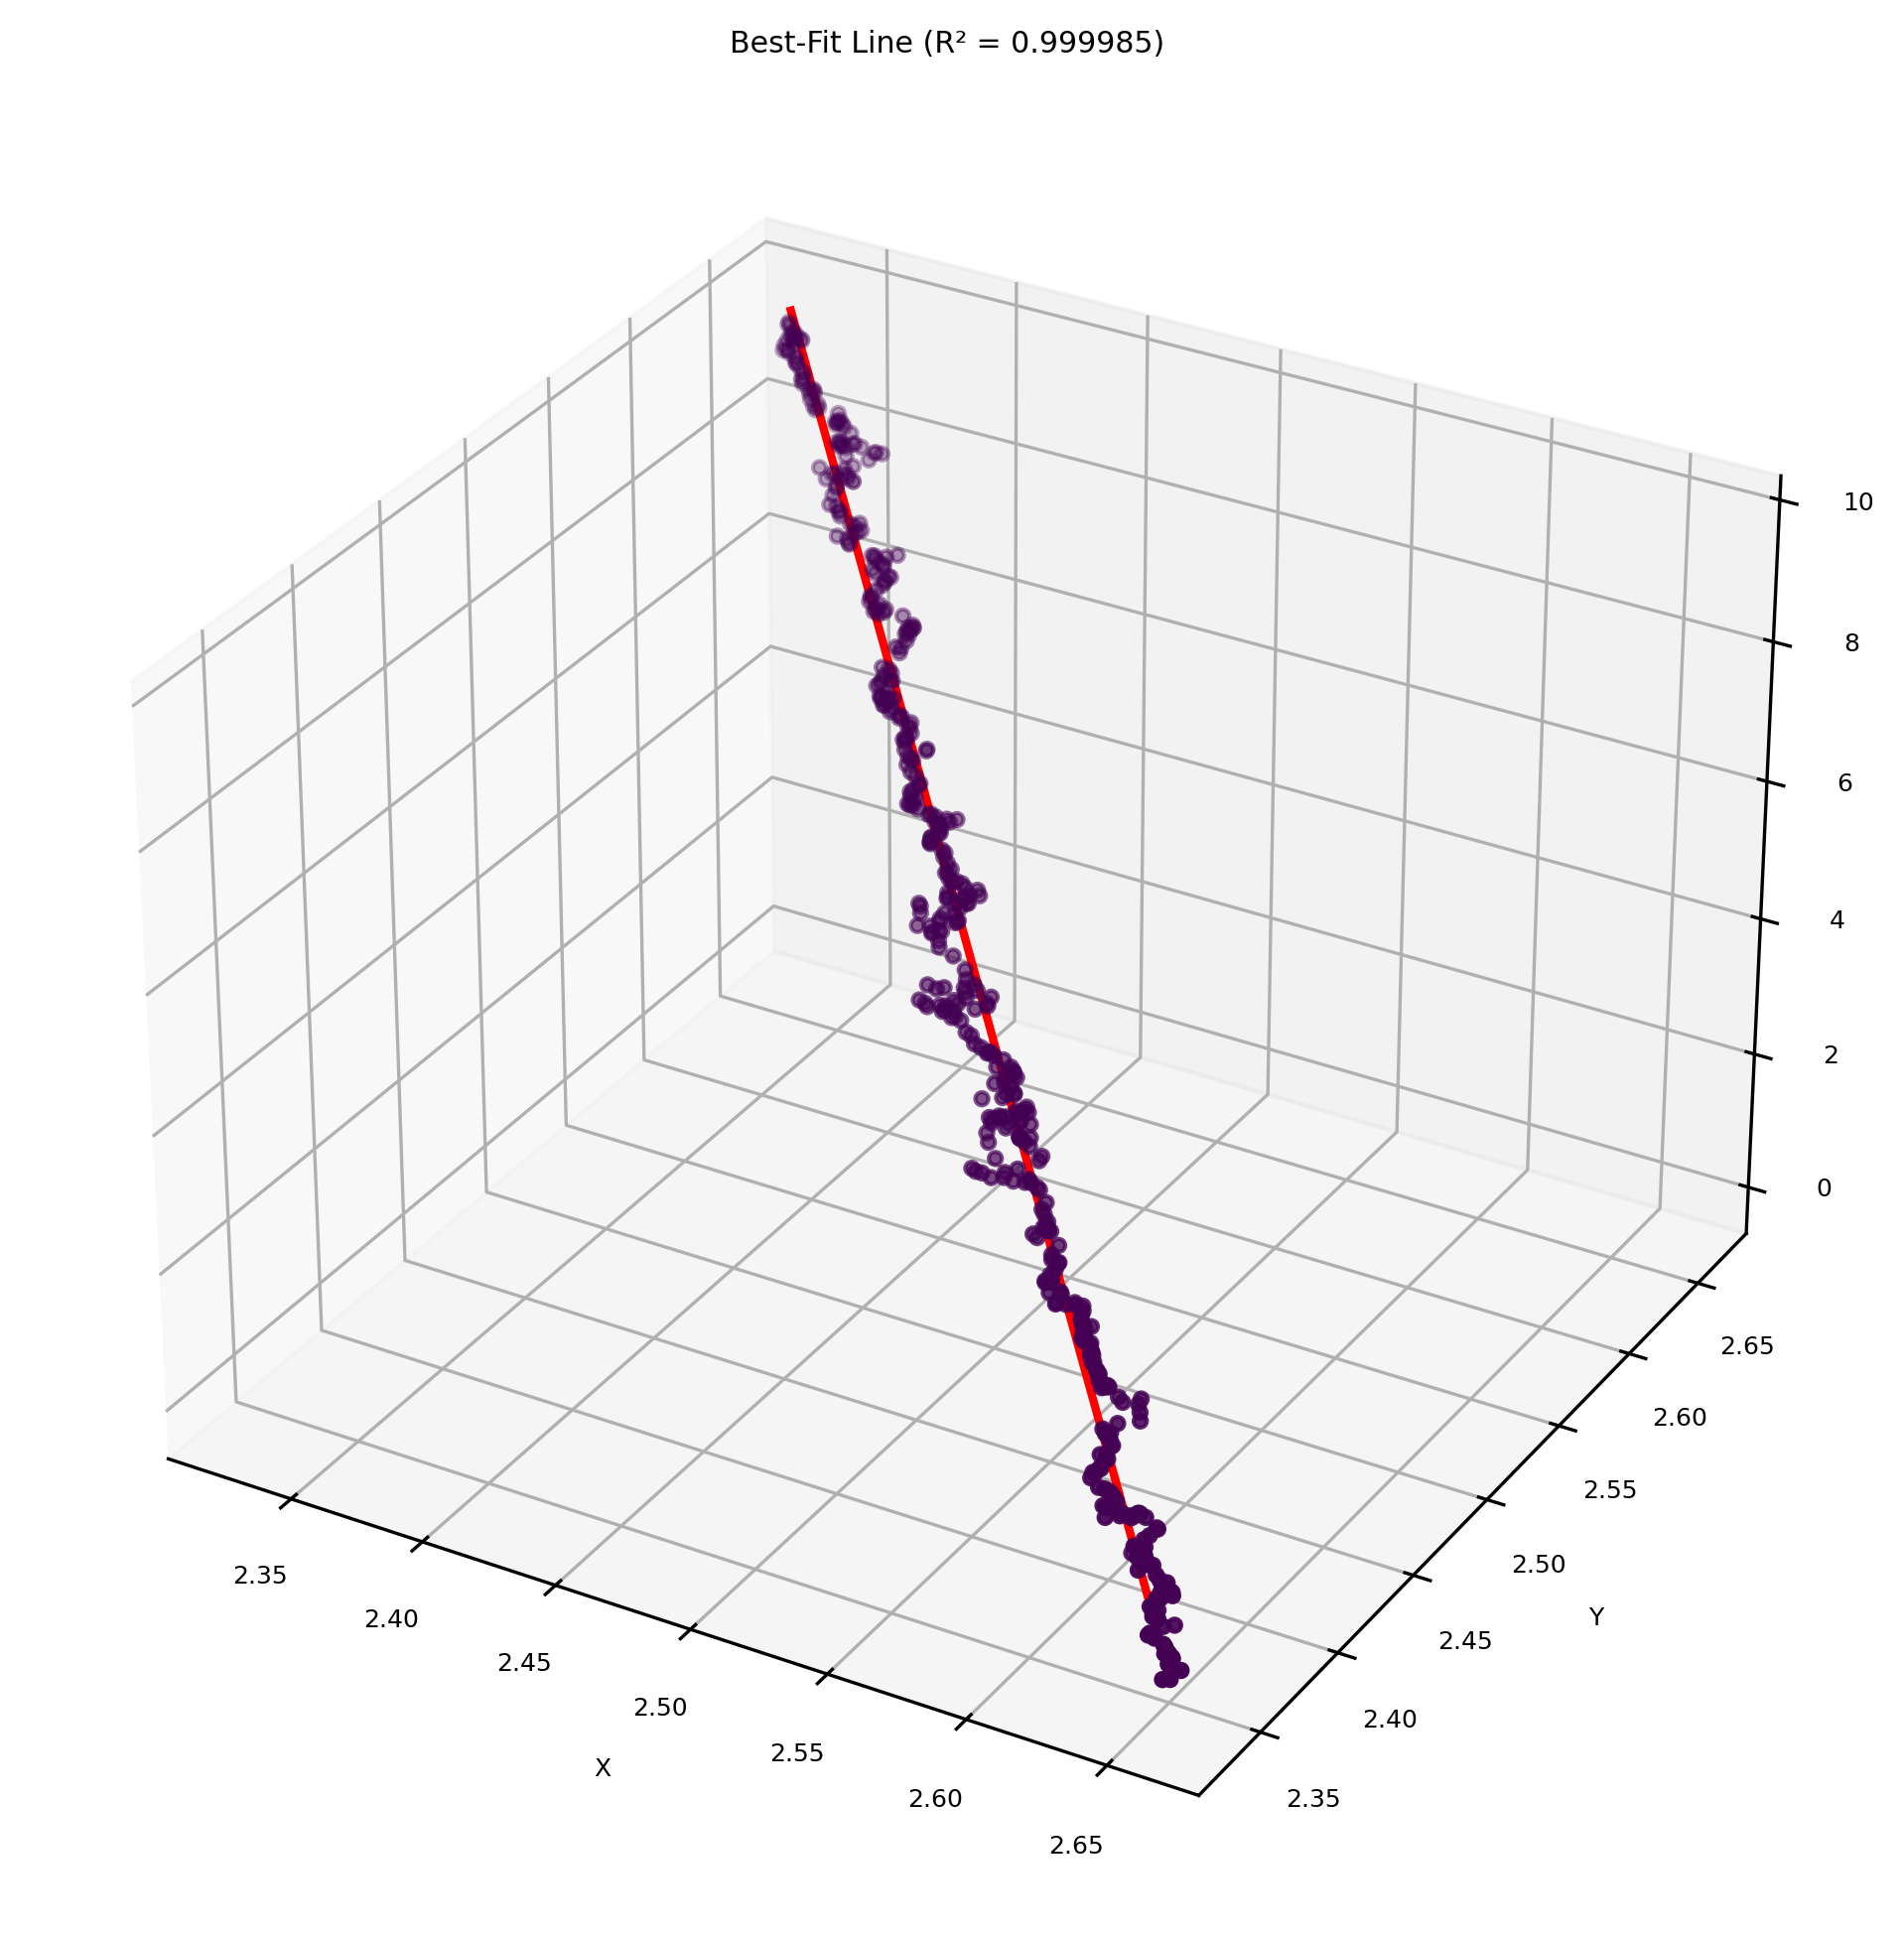

In [19]:
# Barycenters
G = np.array(G_list)
G = G * vs[0]

centroid_base_fit, centroid_top_fit, v_dir = best_fit_segment_3d(G)

#R^2
N = G.shape[0]
dX = G - G.mean(axis=0)
Cmat = (dX.T @ dX) / (N - 1)
U, S, _ = np.linalg.svd(Cmat)
R2 = S[0] / np.sum(S)

# Plot best-fit line with barycenters
fig = plt.figure(figsize=(10,8))
ax2 = fig.add_subplot(111, projection='3d')
ax2.plot([centroid_base_fit[0], centroid_top_fit[0]], [centroid_base_fit[1], centroid_top_fit[1]], [centroid_base_fit[2], centroid_top_fit[2]], '-r', linewidth=2)
ax2.scatter(G[:,0], G[:,1], G[:,2], c=ecc_list, cmap='viridis', s=10)
ax2.set_title(f'Best-Fit Line (R² = {R2:.6f})')
ax2.set_xlabel('X')
ax2.set_ylabel('Y')
ax2.set_zlabel('Z')
plt.show()

In [20]:
np.savetxt('./../../test_data/LHDL/Ti_2923_D_1/results/G_coords.csv', G, delimiter=',')

In [21]:
print(f"Unit vector orienting the axis: [{v_dir[0]}, {v_dir[1]}, {v_dir[2]}]")
print(f"Section eccentricities — mean: {np.mean(ecc_list):.3f}, min: {np.min(ecc_list):.3f}, max: {np.max(ecc_list):.3f}, std: {np.std(ecc_list):.3f}")

Unit vector orienting the axis: [-0.034165595848755434, 0.03348800481040071, 0.9988549772585198]
Section eccentricities — mean: 1.000, min: 1.000, max: 1.000, std: 0.000


### Centroid Coordinates

In [22]:
print(f"Centroid at the base = {G[0]}")
print(f"Centroid at the top = {G[-1]}")
print('--------------------------')
print(f'Best-fit centroid at the base = {centroid_base_fit}')
print(f'Best-fit centroid at the top = {centroid_top_fit}')

Centroid at the base = [2.65685763 2.33806299 0.        ]
Centroid at the top = [2.40875765 2.56569955 9.633     ]
--------------------------
Best-fit centroid at the base = [ 2.65608223e+00  2.33933894e+00 -6.93000859e-05]
Best-fit centroid at the top = [2.32679184 2.66209866 9.62696446]


## Compute the global inclination of a cylindrical sample

This block calculates the global inclination angle of a cylinder relative to the Z-axis:

- The cylinder axis vector is obtained by subtracting the base centroid from the top centroid.
- The unit Z-axis vector `[0, 0, 1]` is used as the reference direction.
- The length of the axis vector is computed using `np.linalg.norm`.
- The cosine of the angle between the cylinder axis and the Z-axis is calculated via the dot product.
- `np.arccos` returns the inclination angle in radians.
- The angle is converted to degrees for interpretation.

All operations follow efficient NumPy vectorized operations.


In [23]:
axis_vector = centroid_top_fit - centroid_base_fit
z_axis = np.array([0, 0, 1])
axis_length = np.linalg.norm(axis_vector)
cos_theta = np.dot(axis_vector, z_axis) / axis_length
theta_rad = np.arccos(cos_theta)
theta_deg = np.degrees(theta_rad)

In [24]:
print(f"Global inclination of the sample relative to the Z axis: {theta_deg:.2f}°")

Global inclination of the sample relative to the Z axis: 2.74°


---
## Computational workflow

### Shell mesh for visualization
**Create a mesh of triangles of the external bone surface (optional)**
Warning: this step is computationally expensive. Only useful for 3D rendering of the bone architecture.
1. Uncomment the following cell to create a shell mesh of triangles

In [25]:
# vertices, triangles, mesh = ciclope.tetraFE.shell_mesh(L, method='pymcubes')

2. Uncomment the following two cells to write the mesh as a VTK file with [meshio](https://github.com/nschloe/meshio)

In [26]:
# filename_shellmesh_out = './../../test_data/LHDL/3155_D_4_bc/results/3155_D_4_bc_shellmesh.vtk'

In [27]:
# meshio.write_points_cells(filename_shellmesh_out, vertices.tolist(), [("triangle", triangles.tolist())])

### Create tetrahedra mesh
Volume meshing using [CGAL](https://www.cgal.org/) through [pygalmesh](https://github.com/nschloe/pygalmesh)

In [28]:
filename_mesh_out = "./../../test_data/LHDL/Ti_2923_D_1/results/Ti_2923_D_1-TETRA4MESH.vtk"

This is the `pygalmesh` function call

In [29]:
# import pygalmesh
# mesh = pygalmesh.generate_from_array(np.transpose(L, [2, 1, 0]).astype('uint8'), tuple(vs), max_facet_distance=1.2*min(vs), max_cell_circumradius=5*1.2*min(vs))

Alternatively use the method `ciclope.core.tetraFE.cgal_mesh`

Reduce `max_facet_distance` (keeping it small for fast execute)

In [30]:
max_facet_distance = 0.5*min(vs)
max_cell_circumradius = 3*min(vs)

In [31]:
with Timer():
    mesh = tetraFE.cgal_mesh(L, vs, 'tetra', max_facet_distance, max_cell_circumradius)

Run time: 0 hours, 6 minutes, 45 seconds


In [32]:
print(mesh)

<meshio mesh object>
  Number of points: 265833
  Number of cells:
    tetra: 1056775
  Point data: medit:ref
  Cell data: medit:ref


In [33]:
mesh.write(filename_mesh_out)

### From TET4 to TET10
#### Mesh conversion from first to second order 

The code cells perform the following operations:
- Identify unique edges of the mesh, avoiding duplicates among tetrahedra.
- Sort the set of edges.
- Determine the positions of the midpoints for each edge.
- Update the mesh cells with the new midpoint positions, converting the mesh from TET4 to TET10.


In [34]:
unique_edges = tetraFE.find_unique_edges(mesh)

In [35]:
sorted_edges = sorted(unique_edges)

In [36]:
edge_to_midpoint = tetraFE.add_midpoints_to_mesh(mesh, sorted_edges)

In [37]:
new_cells = tetraFE.create_new_cells(mesh, edge_to_midpoint)

In [38]:
print(mesh)

<meshio mesh object>
  Number of points: 1769751
  Number of cells:
    tetra10: 1056775
  Point data: medit:ref
  Cell data: medit:ref


In [39]:
filename_mesh_out = "./../../test_data/LHDL/Ti_2923_D_1/results/Ti_2923_D_1-TETRA10MESH.vtk"

In [40]:
mesh.write(filename_mesh_out)

Visualize the mesh with paraview

![TET10mesh_view](./../../test_data/LHDL/Ti_2923_D_1/results/TET10mesh.png)

## Write Abaqus input FE files
### Generate tetrahedra-FE model with constant material properties
The method `ciclope.tetraFE.mesh2tetrafe` assumes that the material property definition is contained in the FE analysis `.INP` template file.

### Automate displacement update in Abaqus .inp file

This step automates the modification of displacement boundary conditions in an Abaqus input file.  
Given a displacement vector `v_dir` and a scalar `top_displacement`, it computes components `Ux, Uy, Uz` and replaces the corresponding boundary values in the input file automatically.

Define displacement vector and scalar displacement value

In [41]:
top_displacement = -0.04

Define displacement scalar

In [42]:
Ux = top_displacement * v_dir[0]
Uy = top_displacement * v_dir[1]
Uz = top_displacement * v_dir[2]

print(f"Calculated displacement components: Ux={Ux:.6f}, Uy={Uy:.6f}, Uz={Uz:.6f}")

Calculated displacement components: Ux=0.001367, Uy=-0.001340, Uz=-0.039954


In [43]:
input_template_inclined = './../../input_templates/tmp_example01_comp_static_inclined_bone.inp'
output_file = './../../input_templates/tmp_example01_comp_static_inclined_bone_temp.inp'

Search for the boundary conditions and replace displacement values with Ux, Uy, Uz

In [44]:
with open(input_template_inclined, 'r') as file:
    lines = file.readlines()

In [45]:
with open(output_file, 'w') as file:
    i = 0
    while i < len(lines):
        line = lines[i]
        if line.strip() == '*BOUNDARY':
            # Controlla se questo blocco è quello di NODES_Z1
            if i + 1 < len(lines) and lines[i+1].startswith('NODES_Z1, 1, 1'):
                # Sostituisci SOLO se è il blocco di NODES_Z1
                file.write(line)  # Scrivi *BOUNDARY una volta
                file.write(f'NODES_Z1, 1, 1, {Ux}\n')
                file.write(f'NODES_Z1, 2, 2, {Uy}\n')
                file.write(f'NODES_Z1, 3, 3, {Uz}\n')
                i += 4  # Salta *BOUNDARY + 3 righe vecchie
                continue
            else:
                # Non è NODES_Z1 → scrivi normalmente
                file.write(line)
        else:
            file.write(line)
        i += 1
        
shutil.move(output_file, input_template_inclined)

'./../../input_templates/tmp_example01_comp_static_inclined_bone.inp'

Inspect inclined input template file

In [46]:
with open(input_template_inclined, 'r') as file:
    content = file.read()
print(content)

** ----------------------------------------------------
** Material definition:
*MATERIAL, NAME=BONE
*ELASTIC
18000, 0.3, 0
*SOLID SECTION, ELSET=SET1, MATERIAL=BONE
** ---------------------------------------------------
** Analysis definition. The Step module defines the analysis steps and associated output requests.
** More info at:
** https://abaqus-docs.mit.edu/2017/English/SIMACAECAERefMap/simacae-m-Sim-sb.htm#simacae-m-Sim-sb
** ---------------------------------------------------
*STEP
*STATIC
** All displacements fixed at bottom:
*BOUNDARY
NODES_Z0, 1, 3, 0.0
** Vertical displacement imposed at top and horizontal displacements fixed:
*BOUNDARY
NODES_Z1, 1, 1, 0.0013666238339502174
NODES_Z1, 2, 2, -0.0013395201924160283
NODES_Z1, 3, 3, -0.03995419909034079
** ---------------------------------------------------
** Output request:
*NODE FILE, OUTPUT=2D
U
*NODE PRINT, TOTALS=ONLY, NSET=NODES_Z0
RF
*EL FILE, OUTPUT=2D
S, E
*END STEP


In [47]:
filename_out = './../../test_data/LHDL/Ti_2923_D_1/results/Ti_2923_D_1_TET10FE.inp'

Generate CalculiX FE input file

In [48]:
with Timer():
    tetraFE.mesh2tetrafe(mesh, input_template_inclined, filename_out, keywords=['NSET', 'ELSET'], float_fmt='.6e', bound_tol=vs[2]*10,
                 inclined=True, plane_norm=v_dir, plane_bottom_origin=centroid_base_fit, plane_top_origin=centroid_top_fit,
                 verbose=True)

Run time: 0 hours, 0 minutes, 26 seconds


In [49]:
filename_out = replace_ElType_ref(filename_out, 'C3D10MH', 'C3D10')

### Visualize NODES_SET in Alba

Display of node sets determined according to the axis of inclination of the sample

![Alba_view](./../../test_data/LHDL/Ti_2923_D_1/results/SET_NODES_ax_inclined.png)

## Solve FE model in calculix
The following section assumes that you have the Calculix solver installed and accessible with the command `ccx_2.17` or for multithread option `ccx_2.17_MT`. <br />
The multithread option in CalculiX is activated by defining the number of threads (default=1) used for the calculation.<br />
This is done by setting the env variable *OMP_NUM_THREADS* with:
`export OMP_NUM_THREADS=8`

In [50]:
#!export OMP_NUM_THREADS=8; ccx_2.17_MT "./../../test_data/LHDL/Ti_2923_D_1/results/Ti_2923_D_1_tetraFE"

Visualize displacement outputs with paraview

![U3_displacements](./../../test_data/LHDL/Ti_2923_D_1/results/LHDL_tetraFE_U3.png)

---
## Convert Calculix output to Paraview
The following sections assume that you have **ccx2paraview** and **Paraview** installed and working.<br /> For more info visit: <br />
- [https://www.paraview.org/](https://www.paraview.org/)
- [https://github.com/calculix/ccx2paraview](https://github.com/calculix/ccx2paraview)

In [51]:
filename_out = './../../test_data/LHDL/Ti_2923_D_1/results/Ti_2923_D_1_TET10FE.inp'

In [52]:
with Timer():
    filename_out_base, ext_out = os.path.splitext(filename_out)
    Converter(filename_out_base + '.frd', ['vtk']).run() #create the file tetraFe.vtk

Run time: 0 hours, 2 minutes, 41 seconds


## Post-process FE analysis results
Display the CalculiX FE output `.DAT` file containing the sum of reaction forces:

In [53]:
filename_dat = filename_out_base + '.dat'

In [54]:
with open(filename_dat, 'r') as file:
    content = file.read()
print(content)


 total force (fx,fy,fz) for set NODES_Z0 and time  0.1000000E+01

       -1.250902E+01 -2.252055E+00  1.910900E+02



### Apparent elastic modulus
`E_app = (F_tot / A) / epsilon`

In [55]:
input_folder = os.path.dirname(input_data)
height_mm = sample_height(input_folder, vs[2])
height_mm = height_mm / resampling
print(f"The sample height is: {round(height_mm)} mm")

The sample height is: 10 mm


In [56]:
displacement = np.sqrt(Ux**2 + Uy**2 + Uz**2)
print(f"The displacement is: {displacement:.2f} mm")

The displacement is: 0.04 mm


In [57]:
epsilon = displacement/(height_mm)
print(f"The deformation is: {epsilon*100:.1f}%")

The deformation is: 0.4%


In [58]:
F_tot = calculate_total_force(filename_dat)
if F_tot is not None:
    print(f"F_tot = {F_tot:.2f} N")

F_tot = 191.51 N


In [59]:
diameter_pixel = 257 # [mm]
diameter_mm = diameter_pixel * vs[2]
A = math.pi * ((diameter_mm)/2)**2 #[mm^2]
E = (F_tot/A)/epsilon
print(f"E_app = {E:.2f} MPa")

E_app = 2342.89 MPa


### Bone Volume Fraction (BV/TV)

The bone volume fraction (**BV/TV**) is calculated as the ratio between the segmented bone volume and the total volume of the scanned region.

The BV/TV result is strongly influenced by the preprocessing steps:
- **Resampling factor:** Changing the resampling factor alters the voxel size and spatial resolution, which affects the computed bone structure.
- **Threshold value:** The threshold used to binarize the image directly determines which voxels are classified as bone.

Always select these parameters carefully and consistently to ensure meaningful and comparable results.


In [60]:
total_volume = A * height_mm
print(f'Total volume = {total_volume:.2f} mm^3')

num_bone_pixel = np.sum(L)
bone_volume = num_bone_pixel * vs[2]**3
print(f'Sample volume = {bone_volume:.2f} mm^3')

BVTV = (bone_volume/total_volume) * 100
print(f"BV/TV = {BVTV:.2f} %")

Total volume = 190.40 mm^3
Sample volume = 41.95 mm^3
BV/TV = 22.03 %


---
# Dependencies

In [61]:
import watermark

In [62]:
%load_ext watermark

%watermark
%watermark --iversions

Last updated: 2025-07-16T14:57:42.463717+02:00

Python implementation: CPython
Python version       : 3.11.11
IPython version      : 8.21.0

Compiler    : MSC v.1942 64 bit (AMD64)
OS          : Windows
Release     : 10
Machine     : AMD64
Processor   : AMD64 Family 23 Model 49 Stepping 0, AuthenticAMD
CPU cores   : 64
Architecture: 64bit

matplotlib  : 3.10.0
scipy       : 1.13.1
ccx2paraview: 3.2.0
skimage     : 0.25.1
sys         : 3.11.11 | packaged by conda-forge | (main, Dec  5 2024, 14:06:23) [MSC v.1942 64 bit (AMD64)]
watermark   : 2.5.0
ciclope     : 1.3.5
meshio      : 5.0.0
numpy       : 1.26.4



---
# Acknowledgements
- This notebook was developed within [Building the Jupyter Community in MSK Imaging Research](https://github.com/JCMSK/2022_JCW), a Jupyter Community Workshop sponsored by [NUMFocus](https://numfocus.org/)